In [217]:
%run functions.ipynb
from sklearn.neural_network import MLPClassifier

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['flatten']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print(
    "(1, 0) labels count in train test: {} {}".format(
        (np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 0)),
        (np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)),
    )
)
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


## Build random forest clasiefier and tree representation

n_variables = 500:

* for n_estimators=500 we can clearly see that either we get extreme overfitting or in case of strong regularization almost all weights go to zero
* even for n_estimator=5 we could get similar results depending on chosen params for the network, however still we didn't manage to improve the results
* the only worth noting point is that logistic regression representation seem to be giving better results, but still these results are  no better than the regression results itself

n_variables = 50:

* random logistics regression are now worse than in the previous case, however it still neural net doesn't provide any improvement

In [192]:
n_estimators = 500
bins = 50

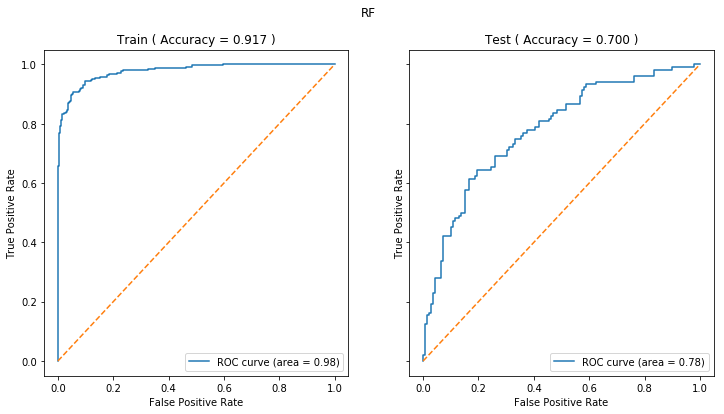

In [193]:
clf_forest = fit_clf(RandomForestClassifier(max_depth=5, n_estimators=n_estimators, min_samples_leaf=10), X_train, y_train, X_test, y_test, title='RF')

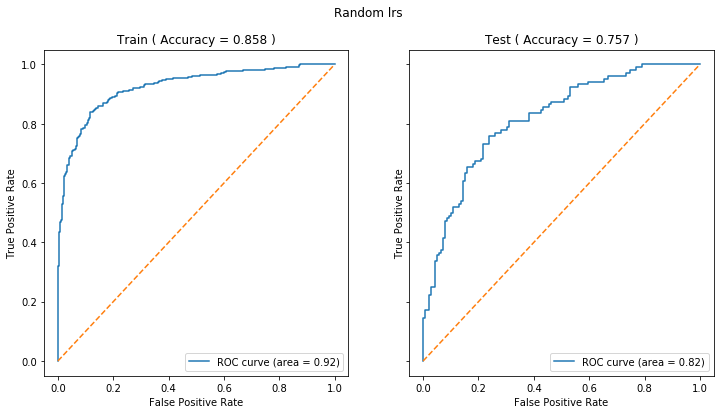

In [194]:
clf_random_lrs = fit_clf(RandomLogisticsRegressions(n_estimators=n_estimators, penalty='l1', C=0.3, n_variables=500), X_train, y_train, X_test, y_test, title='Random lrs')

In [195]:
def get_representation(clf, data):
    result = np.zeros((data.shape[0], len(clf.estimators_)), dtype=np.int32)
    for i, estimator in enumerate(clf.estimators_):
        result[:, i] = estimator.predict(data[:, get_indices(clf, i, data)])
    return result

def get_probabilistic_representation(clf, data):
    result = np.zeros((data.shape[0], len(clf.estimators_)), dtype=np.float32)
    for i, estimator in enumerate(clf.estimators_):
        result[:, i] = estimator.predict_proba(data[:, get_indices(clf, i, data)])[:, 1]
    return result


def get_indices(clf, i, data):
    if isinstance(clf, RandomForestClassifier):
        return np.arange(data.shape[1])
    elif isinstance(clf, RandomLogisticsRegressions):
        return clf.indices[i, :]
    
    raise NotImplementedError("For this type it is not yet implemented")

In [196]:
X_tree_train = get_representation(clf_forest, X_train)
X_tree_test = get_representation(clf_forest, X_test)

X_rlr_train = get_representation(clf_random_lrs, X_train)
X_rlr_test = get_representation(clf_random_lrs, X_test)

In [197]:
X_tree_proba_train = get_probabilistic_representation(clf_forest, X_train)
X_tree_proba_test = get_probabilistic_representation(clf_forest, X_test)

X_rlr_proba_train = get_probabilistic_representation(clf_random_lrs, X_train)
X_rlr_proba_test = get_probabilistic_representation(clf_random_lrs, X_test)

## [fDNN](https://www.nature.com/articles/s41598-018-34833-6) model

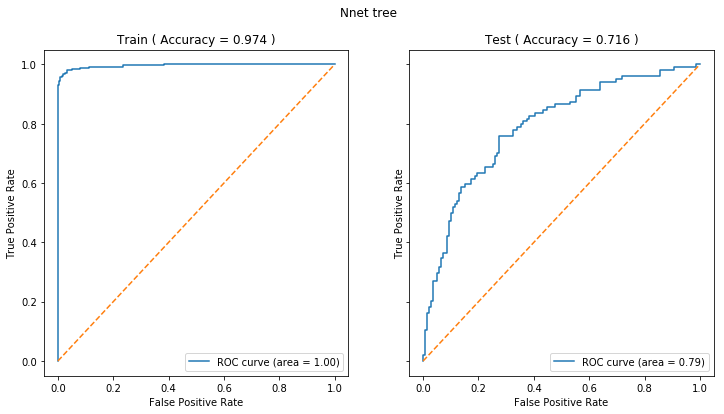

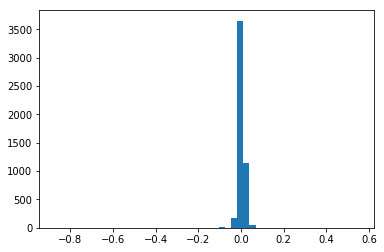

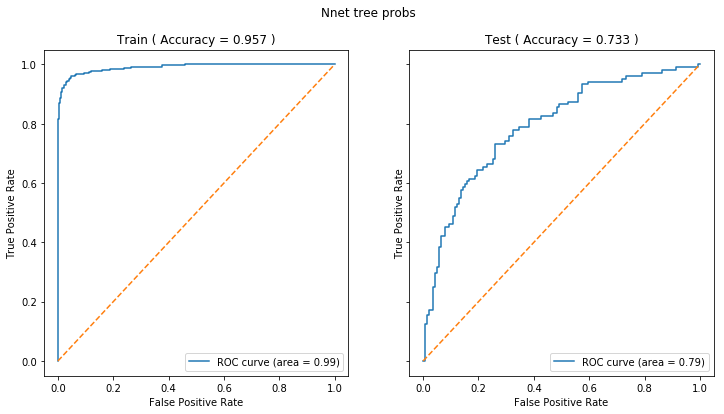

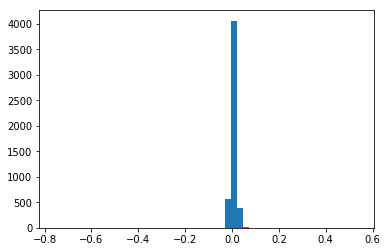

In [198]:
clf_nnet = MLPClassifier(hidden_layer_sizes=[10, 5], max_iter=1000, alpha=20)
clf_nnet = fit_clf(clf_nnet, X_tree_train, y_train, X_tree_test, y_test, title='Nnet tree')

coefs = flatten([coef.flatten().tolist() for coef in clf_nnet.coefs_])
plt.hist(coefs, bins=bins)

clf_nnet = MLPClassifier(hidden_layer_sizes=[10, 5], max_iter=1000, alpha=20)
clf_nnet = fit_clf(clf_nnet, X_tree_proba_train, y_train, X_tree_proba_test, y_test, title='Nnet tree probs')

coefs = flatten([coef.flatten().tolist() for coef in clf_nnet.coefs_])
plt.hist(coefs, bins=bins)

plt.show()

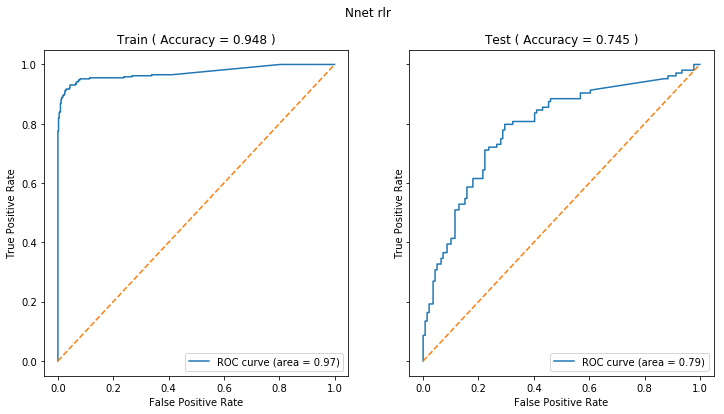

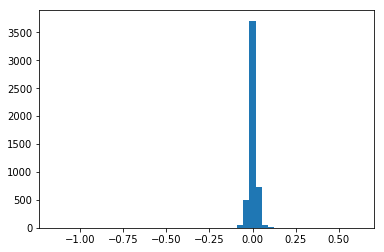

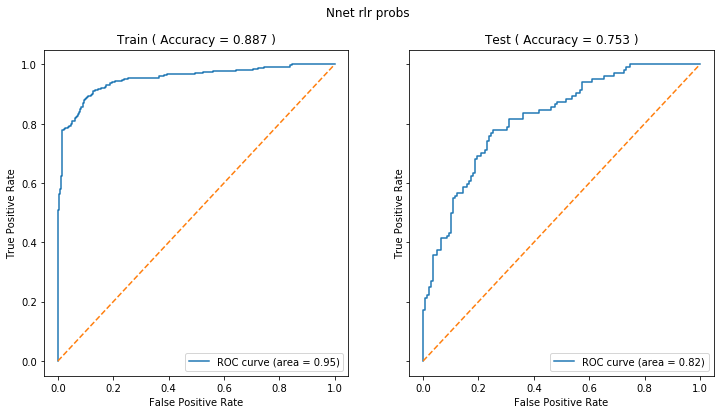

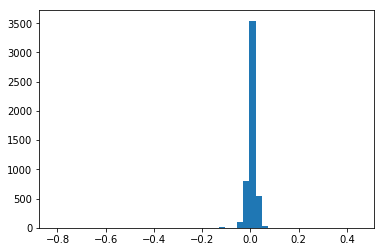

In [202]:
clf_nnet = MLPClassifier(hidden_layer_sizes=[10, 5], max_iter=1000, alpha=10)
clf_nnet = fit_clf(clf_nnet, X_rlr_train, y_train, X_rlr_test, y_test, title='Nnet rlr')

coefs = flatten([coef.flatten().tolist() for coef in clf_nnet.coefs_])
plt.hist(coefs, bins=bins)

clf_nnet = MLPClassifier(hidden_layer_sizes=[10, 5], max_iter=1000, alpha=10)
clf_nnet = fit_clf(clf_nnet, X_rlr_proba_train, y_train, X_rlr_proba_test, y_test, title='Nnet rlr probs')

coefs = flatten([coef.flatten().tolist() for coef in clf_nnet.coefs_])
plt.hist(coefs, bins=bins)

plt.show()

# Random Logistics Regression
Same idea as random forest but instead of decision trees logistics regression is used => best so far

We tested parameters:

* $ C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0] $
* $ n_{variables} = [100, 250, 500, 1000, 2000, 4000, 6000] $
* $ n_{estimators} = [21, 51] $

The differences were not high - AUC varied from $0.75$ to $0.83$ on test set. The effect of overfitting increased with $C$ and $n_{variables}$. We didn't see any significant influence of $n_{estimators}$. From $C = 0.1$ to $C=0.4$ the AUC increased with $n_{variables}$ up to $2000$. For greater values of $C$ the increase stopped at $1000$. 

For the best model we choose $C=0.4, n_{variables}=500$ as it achieved $AUC = 0.83$ with higest accuracy and as it is the smallest from models with such auc score.

### Test different parameters

In [200]:
# for C in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0]:
#     for n_variables in [100, 250, 500, 1000, 2000, 4000, 6000]:
#         for n_estimators in [21, 51]:
#             print(C, n_variables)
#             clf_random_lrs = fit_clf(RandomLogisticsRegressions(n_estimators=21, penalty='l1', C=C, n_variables=n_variables), X_train, y_train, X_test, y_test, title='Random lrs')

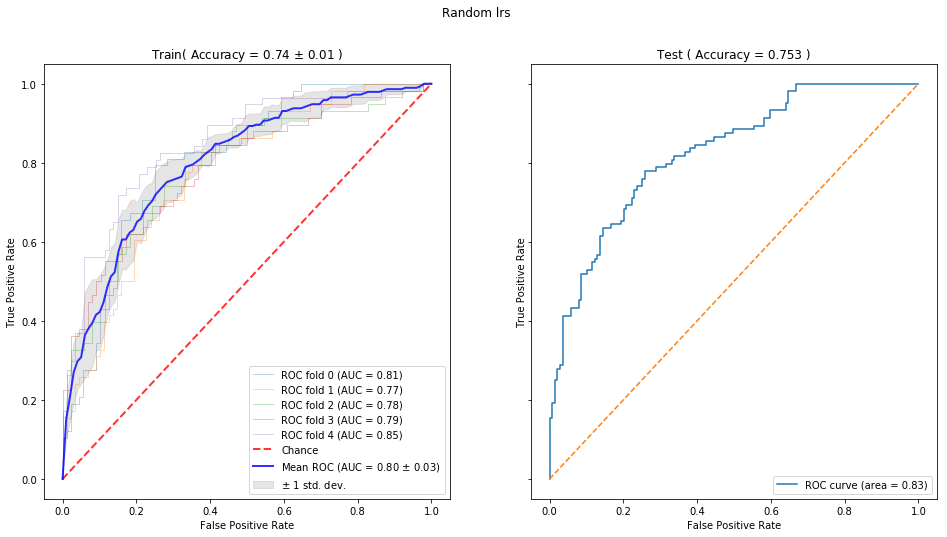

In [219]:
clf_random_lrs = fit_clf_with_cross_val(RandomLogisticsRegressions(n_estimators=21, penalty='l1', C=0.3, n_variables=2000), X_train, y_train, X_test, y_test, title='Random lrs')